In [ ]:
import os
import ffmpeg

def generate_video(image_folder='.'):
    video_name = os.path.join(image_folder, 'video.mp4')

    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith(".png")]

    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")],
                    key=lambda x: int(x.split('.')[0]))

    ffmpeg.input(os.path.join(image_folder, '*.png'), pattern_type='glob', framerate=1).output(video_name, crf=20, preset='slower', pix_fmt='yuv420p').run()

    print(f"Видео сгенерировано: {video_name}")

# Вызов функции генерации видео
generate_video(image_folder='data/out1')


In [17]:
import numpy as np
import cv2
import subprocess

def decay(accumulator, decay_const):
    return accumulator / decay_const

def rejuvenate(fgmask, accumulator, rejuvenate_const):
    fgmask = np.where(fgmask > 0, 1, 0)
    fgmask = np.stack((fgmask,) * 3, axis=-1)
    return np.maximum(accumulator, fgmask * rejuvenate_const)

def process_video(input_file='input_video.mp4', output_file='out.mp4', output=False, decay_rate=1.01):
    video = cv2.VideoCapture(input_file)
    if not video.isOpened():
        print("Ошибка при открытии видеофайла.")
        return
    
    frame_shape = (int(video.get(4)), int(video.get(3)), 3)
    decay_const = np.full(frame_shape, [decay_rate, 1, 1])
    rejuvenate_const = np.full(frame_shape, [179, 225, 225])
    accumulator = np.full(frame_shape, [0, 225, 225])
    
    bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
    
    frames = []
    
    while video.isOpened():
        try:
            ok, frame = video.read()
            if not ok:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fgmask = bg_subtractor.apply(gray)
            accumulator = decay(accumulator, decay_const)
            accumulator = rejuvenate(fgmask, accumulator, rejuvenate_const)
            frame = cv2.cvtColor(accumulator.astype(np.uint8), cv2.COLOR_HSV2BGR)
            frames.append(frame)
        except KeyboardInterrupt:
            break
    
    if output:
        command = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'rawvideo',
            '-vcodec', 'rawvideo',
            '-s', f"{frame_shape[1]}x{frame_shape[0]}",  # size of one frame
            '-pix_fmt', 'bgr24',
            '-r', str(int(video.get(5))),  # frame rate of the input video
            '-i', '-',  # input comes from a pipe
            '-c:v', 'libx264',
            '-preset', 'ultrafast',
            '-crf', '25',  # constant rate factor
            output_file
        ]
        
        try:
            process = subprocess.Popen(command, stdin=subprocess.PIPE)
            for frame in frames:
                process.stdin.write(frame.tobytes())
            process.stdin.close()
            process.wait()
        except Exception as e:
            print("Ошибка при записи видео:", e)
            return
    
    video.release()
    return frames

# Здесь вы можете задать параметры, если запускаете скрипт напрямую
images = process_video(input_file='data/out1/video.mp4', output_file='data/out1/motions.mp4', output=True, decay_rate=1.4)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [23]:
from IPython.display import Video

Video("data/out1/video.mp4", width=800, height=450)

In [18]:
Video("data/out1/motions.mp4", width=800, height=450)

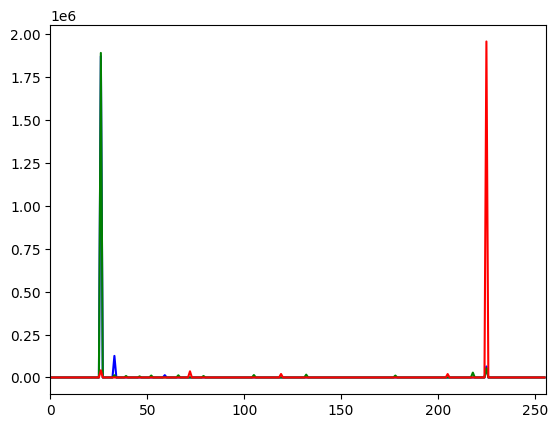

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = images[len(images)//2]
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

## Обучение

In [ ]:
import cv2
import numpy as np

# Function to generate motion heatmap and save it as a video
def save_motion_heatmap(video_path, output_path, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2):
    """
    Generates a motion heatmap from a video file using the Farneback optical flow method.

    Parameters:
        video_path (str): Path to the input video file.
        output_path (str): Path to save the output motion heatmap video.
        pyr_scale (float): Scale factor for building the image pyramid. Default is 0.5.
        levels (int): Number of pyramid layers. Default is 3.
        winsize (int): Size of the averaging window for each pyramid level. Default is 15.
        iterations (int): Number of iterations at each pyramid level. Default is 3.
        poly_n (int): Size of the pixel neighborhood used to find polynomial expansion in each pixel. Default is 5.
        poly_sigma (float): Standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion. Default is 1.2.
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    # Get video frame properties
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'h264')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255

    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0)

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        out.write(bgr)

        prvs = next

    # Release video capture and writer objects
    cap.release()
    out.release()

# Example usage with custom parameters
save_motion_heatmap('data/out1/video.avi', 
                    'data/output_motions_4.mp4', 
                    pyr_scale=0.5, 
                    levels=5, 
                    winsize=10, 
                    iterations=5,
                    poly_n=7, 
                    poly_sigma=1.4)


OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@0.039] global cap_ffmpeg_impl.hpp:3130 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@0.039] global cap_ffmpeg_impl.hpp:3208 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


In [ ]:
class Chicken_Entropy():
    def __init__(self) -> None:
        """
        Initialize the MyDetector object.

        Args:
            model_path (str): Path to the model file.
            size (tuple): Size of the input image.

        Returns:
            None
        """
        self._session = onnxruntime.InferenceSession(model_path)
        self.input_name = self._session.get_inputs()[0].name
        self.output_names = [self._session.get_outputs()[0].name]
        self._size = size
        self.classes = classes
        self.model_name = model_name
        
    def _preprocess(self, rgb_img):
        """
        Performs preprocessing transformation for model.

        Args:
            rgb_img (numpy.ndarray): Input RGB image.

        Returns:
            numpy.ndarray: Output of the transformation.
        """
        
        return 
        
    
    def forward(self, rgb_img):
        """
        Performs forward pass on the input image.

        Args:
            rgb_img (numpy.ndarray): Preprocessed input RGB image.

        Returns:
            numpy.ndarray: Output of the forward pass.
        """
        input_image = np.expand_dims(rgb_img, axis=0).astype('float32')
        input_image = np.transpose(input_image, [0, 3, 1, 2])
        return self._session.run(None, {self.input_name: input_image})[0]        
    
    
    def post_process(self, output):
        """
        Post-process the output of the model.

        Args:
            output (tuple): Output of the model.

        Returns:
            tuple: Processed bounding boxes and class IDs.
        """
        
    

    def video_run(self, cap):
        """
        Process video frames and draw bboxes.

        Args:
            cap: Video capture object.

        Returns:
            io.BytesIO: In-memory file containing the processed video.
        """
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        # Create BYTETracker instance
        byte_tracker = BYTETracker(BYTETrackerArgs(), frame_rate=fps)
        
        # Video stream handling 
        output_memory_file = io.BytesIO()
        output_f = av.open(output_memory_file, 'w', format="mp4")  # Open "in memory file" as MP4 video output
        stream = output_f.add_stream('h264', str(fps))  # Add H.264 video stream to the MP4 container, with framerate = fps.
        # Video capturing
        while True:
            ret, frame = cap.read()
            if not ret:
                break
               
            preprocessed_img, resized_img = self._preprocess(frame)
#             print(preprocessed_img)
            
            xyxy, confidence = self.post_process(self.forward(preprocessed_img))
#             print("first", xyxy[:3])
#             print("second", confidence[:3])
#             print("third", np.hstack((xyxy, confidence[:, np.newaxis])[:3]))
            # Tracking detections
            tracks = byte_tracker.update(
                output_results=np.hstack((xyxy, confidence[:, np.newaxis])),
                img_info=preprocessed_img.shape,
                img_size=preprocessed_img.shape
            )
            tracker_id = self._match_detections_with_tracks(xyxy, tracks)
            
            # Filtering out detections without trackers
            mask = np.array([idx is not None for idx in tracker_id], dtype=bool)
            xyxy = xyxy[mask]
            confidence = confidence[mask]
            tracker_id = tracker_id[mask]
            
            # Drawing bboxes with labels
            for box, score, idx in zip(xyxy, confidence, tracker_id):
                self.draw_detections(img=resized_img, box=box, score=score, tracker_id=idx)
            
            # Convert image from NumPy Array to frame.
            resized_img = av.VideoFrame.from_ndarray(resized_img, format='bgr24') 
            packet = stream.encode(resized_img)  # Encode video frame
            output_f.mux(packet)  # "Mux" the encoded frame (add the encoded frame to MP4 file).
            
        # Flush the encoder
        packet = stream.encode(None)
        output_f.mux(packet)
        output_f.close()
        return output_memory_file

    
    def __call__(self, cap):
        """
        Call the MyDetector object to process input video.

        Args:
            cap: Video capture object.

        Returns:
            io.BytesIO: In-memory file containing the processed video.
        """
        return self.video_run(cap)